In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random

In [5]:
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Check underdamped condition
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure that μ^2 < 4 * m * k.")
    
    # Angular frequency
    omega = np.sqrt(k/m - (mu/(2*m)) ** 2)
    
    # Exact solution
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2 * m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    
    return y_exact

# Find failure probability 

In [ ]:
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define the PINN model
class PINN_m(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(PINN_m, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)

class PINN_m_mu(PINN_m):
    def forward(self, t, m, mu, k, y0, v0):
        N = m.shape[0]
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu, k_, y0_, v0_], dim=1)
        return self.net(x)

class PINN_all(PINN_m):
    def forward(self, t, m, mu, k, y0, v0):
        x = torch.cat([t, m, mu, k, y0, v0], dim=1)
        return self.net(x)

# Compute PDE loss
def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = model(t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2)

# Compute boundary loss
def boundary_loss(model, t0, m, mu, k, y0, v0):
    y_pred = model(t0, m, mu, k, y0, v0)
    y_t = torch.autograd.grad(y_pred, t0, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return torch.mean((y_pred - y0)**2 + (y_t - v0)**2)

def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Initialize training parameters
def initialize_uniform_mass(m_mean=1.0, m_std=0.1):
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = m_mean, m_std
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 8 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

def initialize_uniform_mass_mu(m_mean=1.0, m_std=0.1, mu_mean=0.6, mu_std=0.05):
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = m_mean, m_std
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 8 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu_mean, mu_std = mu_mean, mu_std
    mu_coll = torch.FloatTensor(N, 1).uniform_(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std)
    mu_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    k, y0, v0 = 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_coll, k_val, y0_val, v0_val, t0

def initialize_uniform_all():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    mu_mean, mu_std = 0.6, 0.05
    k_mean, k_std = 5.0, 0.5
    y0_mean, y0_std = -0.4, 0.1
    v0_mean, v0_std = 3.0, 0.5
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 4 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu_coll = torch.FloatTensor(N, 1).uniform_(mu_mean - 2 * mu_std, mu_mean + 4 * mu_std)
    mu_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    k_coll = torch.FloatTensor(N, 1).uniform_(k_mean - 2 * k_std, k_mean + 4 * k_std)
    k_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    y0_coll = torch.FloatTensor(N, 1).uniform_(y0_mean - 2 * y0_std, y0_mean + 4 * y0_std)
    y0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    v0_coll = torch.FloatTensor(N, 1).uniform_(v0_mean - 2 * v0_std, v0_mean + 4 * v0_std)
    v0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0

# Trainer class to manage training process
class Trainer:
    def __init__(self, model, optimizer, epochs=4001, lambda_bc=10.0):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": [], "Boundary Loss": []}
        self.lambda_bc = lambda_bc
    
    def train(self, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0):
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val)
            loss_bc = boundary_loss(self.model, t0, m_val, mu_val, k_val, y0_val, v0_val)
            loss = loss_pde + self.lambda_bc * loss_bc
            loss.backward()
            self.optimizer.step()
            
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())
            
            # if epoch % 1000 == 0:
                 
            #     m_val = update_mass()

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
                plot_loss(range(epoch + 1), self.losses)

## Finding MPP

### Uniformely distributed mass

Epoch 0, PDE loss: 0.8752022981643677, BC loss: 9.250069618225098


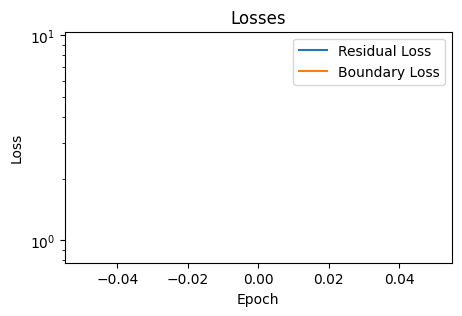

Epoch 1000, PDE loss: 0.34547358751296997, BC loss: 0.0009691172745078802


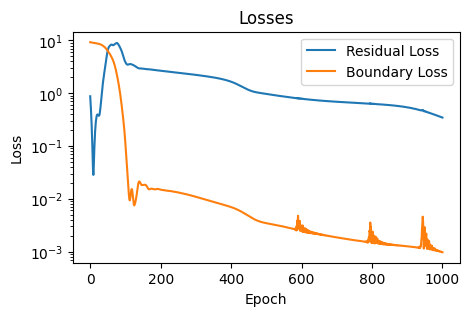

Epoch 2000, PDE loss: 0.0927608460187912, BC loss: 0.0002352774317841977


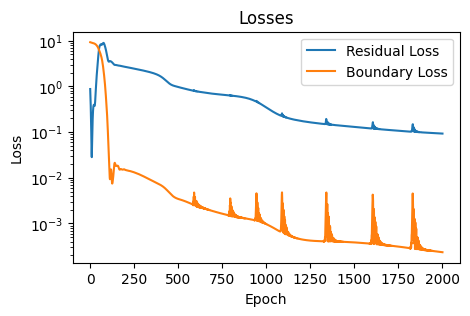

Epoch 3000, PDE loss: 0.06062218174338341, BC loss: 0.00013417238369584084


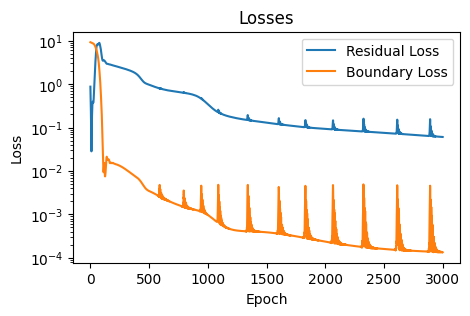

Epoch 4000, PDE loss: 0.03950357064604759, BC loss: 0.00010851055412786081


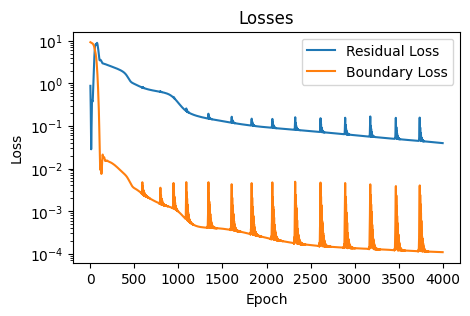

In [80]:
# Run training pipeline
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass_mu()
mass_mu_model = PINN_m_mu(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(mass_mu_model.parameters(), lr=0.001)
trainer = Trainer(mass_mu_model, optimizer,epochs=4001)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)

Below is an example of how you can build on your existing training code to search for candidate (mass, μ) pairs where the predicted minimum output is close to –1 (i.e. where

  g(m, μ) = min(model_prediction) + 1 ≈ 0),

while also keeping the search focused near the mean of your input distributions. In this example the candidate objective is defined as

  Objective(x) = |g(x)| + λ · [((mass – mass_mean)/mass_std)² + ((μ – μ_mean)/μ_std)²].

This formulation biases the search toward the “most probable point” (MPP) while still using a multi‐start, derivative‐free optimizer (Nelder–Mead) so that if there are additional failure regions, you can capture them by running several initial guesses.

## How This Works

### Candidate Evaluation (candidate_g)
For a given candidate \( x = [\text{mass}, \mu] \), the function creates tensors (with the same time-collocation points) and evaluates the PINN model. It then computes the minimum predicted output and adds 1 so that failure (when the oscillator reaches –1) corresponds to \( g(x) = 0 \).

### Candidate Objective
The objective is the absolute value of \( g(x) \) plus a penalty that grows as the candidate moves away from the mean values. This encourages the optimizer to prefer candidate points near the most probable region.

### Multi-Start Optimization
The code uses several random starting points (drawn from the input distributions) with SciPy’s `minimize` (using Nelder–Mead) to search for candidate points that satisfy the criterion. You then cluster these points to remove duplicates.

### Visualization
A contour plot of the candidate objective over a grid in (mass, μ) space is shown with the candidate points overlaid. This helps verify that the optimizer is finding regions on the failure boundary.

## Additional Thoughts
Since your PINN is differentiable (using `loss.backward()`), you could in principle compute gradients with respect to the input parameters and use a gradient-based method (or even form a Lagrangian \( L(x, \lambda) = \|x - \mu\|^2 + \lambda g(x) \)) to refine the search. This code uses a derivative-free approach for simplicity, but you might later experiment with methods that incorporate the PINN’s gradients directly.

The penalty term here does bias the optimization toward the MPP (most probable point). If you want to capture other failure regions on the \( g(x) = 0 \) manifold, you could run additional searches with a reduced penalty (or remove it altogether) and then compare the candidate clusters.

This integrated code should give you a good starting point for adaptively finding parameter values to focus your further training. Let me know if you need more details or further refinements!



Unique candidate points for further training:
mass = 1.2561, mu = 0.3698
mass = 1.1971, mu = 0.2843
mass = 1.2212, mu = 0.3203
mass = 1.1405, mu = 0.2023
mass = 1.0677, mu = 0.0882
mass = 1.2283, mu = 0.3309
mass = 1.1439, mu = 0.2075
mass = 1.1896, mu = 0.2744
mass = 1.1516, mu = 0.2189
mass = 1.1167, mu = 0.1654
mass = 1.2222, mu = 0.3218
mass = 1.2378, mu = 0.3446
mass = 1.1989, mu = 0.2867
mass = 1.1648, mu = 0.2389
mass = 1.2327, mu = 0.3373
mass = 1.1246, mu = 0.1779
mass = 1.2428, mu = 0.3515
mass = 1.2468, mu = 0.3569
mass = 1.1149, mu = 0.1625


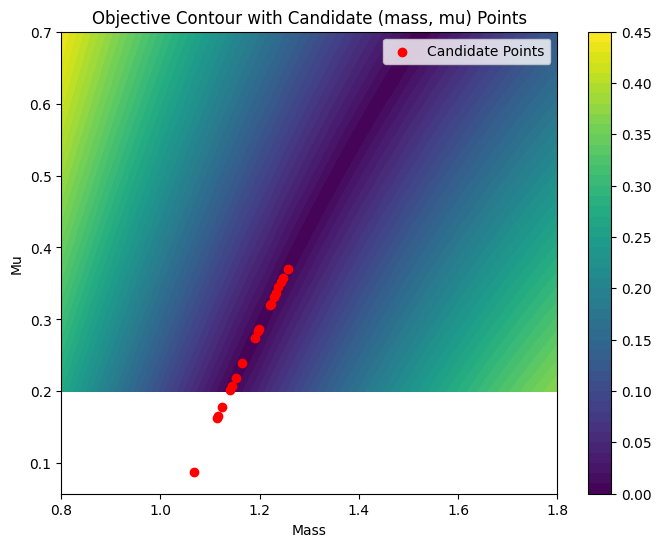

In [119]:
from scipy.optimize import minimize
# --- Candidate Search for (mass, mu) where g(x)=min(y_pred)+1 ≈ 0 ---
# We assume that during candidate search we fix the other parameters to the trained (or nominal) values:
mass_mean = 1.0
mass_std = 0.1
mu_mean = 0.6
mu_std = 0.05
lambda_penalty = 0.00  # Adjust the weight as needed

# Extract fixed parameter values (as scalars)
k = k_val.item()
y0 = y0_val.item()
v0 = v0_val.item()

def candidate_g(x, t_coll, k, y0, v0):
    """
    Given x = [mass, mu], evaluate g(x) = min(model_prediction) + 1 over the collocation points.
    """
    mass_val, mu_val_candidate = x
    # Create tensors for mass and mu that match the shape of t_coll
    m_tensor = torch.full_like(t_coll, mass_val)
    mu_tensor = torch.full_like(t_coll, mu_val_candidate)
    k_tensor = torch.full_like(t_coll, k)
    y0_tensor = torch.full_like(t_coll, y0)
    v0_tensor = torch.full_like(t_coll, v0)
    # Evaluate the model (set to eval mode and no grad)
    mass_mu_model.eval()
    with torch.no_grad():
        y_pred = mass_mu_model(t_coll, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor)
    y_min = y_pred.min()
    return y_min.item() + 1.0  # g(x) = predicted_minimum + 1.0

def candidate_objective(x, t_coll, k, y0, v0, mass_mean, mass_std, mu_mean, mu_std, lambda_penalty):
    """
    Objective function: minimize |g(x)| while penalizing deviation from the input means.
    """
    g_val = candidate_g(x, t_coll, k, y0, v0)
    penalty = lambda_penalty * ( ((x[0] - mass_mean)/mass_std)**2 + ((x[1] - mu_mean)/mu_std)**2 )
    return abs(g_val) + penalty

def find_candidate_points(n_initial, t_coll, k, y0, v0, mass_mean, mass_std, mu_mean, mu_std, lambda_penalty):
    candidate_points = []
    for i in range(n_initial):
        # Start with a random guess drawn from the input distributions.
        init_mass = np.random.uniform(mass_mean, mass_std+5 * mass_std)
        init_mu = np.random.uniform(mu_mean - 5 * mu_std, mu_mean )
        init_guess = [init_mass, init_mu]
        res = minimize(
            candidate_objective, 
            init_guess, 
            args=(t_coll, k, y0, v0, mass_mean, mass_std, mu_mean, mu_std, lambda_penalty),
            method='Nelder-Mead'
        )
        if res.success:
            candidate_points.append(res.x)
        else:
            print(f"Start {i}: Optimization did not converge from initial guess {init_guess}")
    return candidate_points

# Run the multi-start candidate search:
n_initial = 20  # number of initial guesses
candidates = find_candidate_points(n_initial, t_coll, k, y0, v0,
                                   mass_mean, mass_std, mu_mean, mu_std, lambda_penalty)

# Optionally, remove duplicates (if candidate points are very close)
unique_candidates = []
tol = 1e-3
for pt in candidates:
    if not any(np.linalg.norm(pt - np.array(up)) < tol for up in unique_candidates):
        unique_candidates.append(pt)

print("\nUnique candidate points for further training:")
for pt in unique_candidates:
    print(f"mass = {pt[0]:.4f}, mu = {pt[1]:.4f}")

# --- Optional: Visualization of the Candidate Objective ---
mass_vals = np.linspace(mass_mean - 2 * mass_std, mass_mean + 8 * mass_std, 100)
mu_vals = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100)
Mass, Mu = np.meshgrid(mass_vals, mu_vals)
Obj = np.zeros_like(Mass)

for i in range(Mass.shape[0]):
    for j in range(Mass.shape[1]):
        Obj[i, j] = candidate_objective([Mass[i, j], Mu[i, j]], t_coll, k, y0, v0,
                                        mass_mean, mass_std, mu_mean, mu_std, lambda_penalty)

plt.figure(figsize=(8, 6))
cp = plt.contourf(Mass, Mu, Obj, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.scatter([pt[0] for pt in unique_candidates], [pt[1] for pt in unique_candidates],
            color='red', label='Candidate Points')
plt.xlabel('Mass')
plt.ylabel('Mu')
plt.title('Objective Contour with Candidate (mass, mu) Points')
plt.legend()
plt.show()


In [117]:
mass = 1.3737
mu = 0.5239
t_test = torch.linspace(0, 5, 100).view(-1, 1)
m_test = torch.tensor([mass] * len(t_test), dtype=torch.float32).view(-1, 1)
mu_test = torch.tensor([mu] * len(t_test), dtype=torch.float32).view(-1, 1)
y_pred= mass_mu_model(t_test, m_test, mu_test, k_val, y0_val, v0_val).min()
print(y_pred)

y_actual = damped_harmonic_oscillator(t_test, m=mass, mu=mu, k=k, y0=y0, v0=v0).min()
print(y_actual)

tensor(-0.9993, grad_fn=<MinBackward1>)
tensor(-0.9708)


Below is an example that demonstrates how to compute the gradient of your limit‐state function g(x) with respect to the input parameters (here, mass and μ) and how to set up a simple Lagrangian in PyTorch. In this example, we define

  g(x) = min(model_prediction(x)) + 1.0

where the model is your trained PINN. We then form a Lagrangian

  L(x, λ) = ‖x – μ_mean‖² + λ · g(x)

and show how you can compute the gradients with respect to both x and the multiplier λ.

Note: Because the min() operation may be non‐smooth, you might consider using a smooth approximation (e.g. a softmin) if you encounter difficulties. For illustration, we use torch.min below.

## Explanation
### Computing g(x):
The function compute_g(x, t_coll, k, y0, v0) constructs tensors for the mass and damping parameters (from x) that match the collocation points t_coll. It then runs the trained model to compute the predicted oscillator outputs and returns the value of
  g(x) = min(model_prediction) + 1.0.

The gradient of g(x) with respect to x is obtained using torch.autograd.grad.

### Setting Up the Lagrangian:
We form the Lagrangian
  L(x, λ) = ‖x – μ_mean‖² + λ · g(x)

where the first term penalizes deviation from the mean, and the second enforces the constraint g(x)=0.

We initialize x (our candidate parameters) and λ as learnable tensors (with requires_grad=True), and then set up an optimizer (here Adam) to update both.

### Optimization Loop:
In each iteration, we compute g(x) and the squared distance term, form the Lagrangian, call backward() to compute gradients, and then step the optimizer. Over iterations, if a feasible solution exists, x should be driven to a region where g(x) is close to zero, while also trying to stay near the mean.

### Using Gradients:
The code snippet shows how to compute the gradient of g(x) explicitly (with torch.autograd.grad), which is useful if you want to analyze the sensitivity of g or include higher-order derivatives in your optimization.

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Suppose mass_model is your trained PINN (an instance of PINN_m)
# And t_coll is your collocation points tensor (with shape [N, 1])
# Fixed parameters (scalars)
k = 5.0
y0 = -0.4
v0 = 3.0

# Parameter distribution means and stds (for mass and mu)
mass_mean = 1.0
mass_std = 0.1
mu_mean = 0.6
mu_std = 0.1

# Example collocation points (if not already defined)
N = 500
t_coll = torch.rand(N, 1) * 5.0
t_coll.requires_grad = True

# Define a function to compute g(x)
def compute_g(x, t_coll, k, y0, v0):
    """
    x: a tensor of shape (2,) representing [mass, mu], with requires_grad=True.
    Returns:
       g(x) = min(model_prediction) + 1.0 over the collocation points.
    """
    mass_val, mu_val = x[0], x[1]
    # Create tensors matching t_coll's shape
    m_tensor = mass_val * torch.ones_like(t_coll)
    mu_tensor = mu_val * torch.ones_like(t_coll)
    k_tensor = k * torch.ones_like(t_coll)
    y0_tensor = y0 * torch.ones_like(t_coll)
    v0_tensor = v0 * torch.ones_like(t_coll)
    
    # Set model to evaluation mode
    mass_mu_model.eval()
    # Compute model predictions (ensure no grad for intermediate forward pass)
    y_pred = mass_mu_model(t_coll, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor)
    
    # Compute g as min(y_pred) + 1.0.
    # (For a differentiable approximation, consider a smooth-min if needed.)
    g_val = torch.min(y_pred) + 1.0
    return g_val

# Example: Compute gradient of g(x) with respect to x
# Start with an initial guess for x = [mass, mu]
x = torch.tensor([mass_mean, mu_mean], dtype=torch.float32, requires_grad=True)

g_val = compute_g(x, t_coll, k, y0, v0)
# Compute gradient using torch.autograd.grad; create_graph=True allows higher derivatives.
grad_g = torch.autograd.grad(g_val, x, create_graph=True)[0]
print("g(x) =", g_val.item())
print("Gradient of g(x) w.r.t x:", grad_g)

# --- Setting Up the Lagrangian ---

# We now set up the Lagrangian L(x, λ) = ‖x - μ_mean_vector‖² + λ * g(x)
# where μ_mean_vector = [mass_mean, mu_mean]

# Initialize x and the Lagrange multiplier lambda (as a learnable parameter)
x = torch.tensor([mass_mean, mu_mean], dtype=torch.float32, requires_grad=True)
lam = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# Define an optimizer that will update both x and lam
optimizer = optim.Adam([x, lam], lr=1e-3)

# Run a few iterations to see how the gradients update the variables
n_iter = 2000
for i in range(n_iter):
    optimizer.zero_grad()
    
    # Compute g(x)
    g_val = compute_g(x, t_coll, k, y0, v0)
    # Compute the distance squared from the mean (for both mass and mu)
    mean_vec = torch.tensor([mass_mean, mu_mean], dtype=torch.float32)
    dist_sq = torch.sum((x - mean_vec)**2)
    # Form the Lagrangian: we want g(x)=0 and x close to the mean
    Lagrangian = dist_sq + lam * g_val
    
    Lagrangian.backward()
    optimizer.step()
    
    # (Optional) Print progress every 200 iterations
    if i % 200 == 0:
        print(f"Iteration {i}: Lagrangian = {Lagrangian.item():.6f}, g(x) = {g_val.item():.6f}, x = {x.detach().numpy()}, lambda = {lam.item():.6f}")

# After optimization, x should be near a point where g(x) ≈ 0 (if feasible)
print("Optimized x (mass, mu):", x.detach().numpy())
print("Optimized Lagrange multiplier lambda:", lam.item())


g(x) = 0.3506089448928833
Gradient of g(x) w.r.t x: tensor([-0.6109,  0.4441], grad_fn=<AddBackward0>)
Iteration 0: Lagrangian = 0.000000, g(x) = 0.350609, x = [1.  0.6], lambda = -0.001000
Iteration 200: Lagrangian = -0.078804, g(x) = 0.411469, x = [0.93479574 0.64504254], lambda = -0.207668
Iteration 400: Lagrangian = -0.177078, g(x) = 0.479523, x = [0.85904473 0.68986285], lambda = -0.428330
Iteration 600: Lagrangian = -0.296003, g(x) = 0.546050, x = [0.7850364  0.73327243], lambda = -0.660224
Iteration 800: Lagrangian = -0.435162, g(x) = 0.614728, x = [0.7033009  0.77178967], lambda = -0.899806
Iteration 1000: Lagrangian = -0.590739, g(x) = 0.651386, x = [0.65979284 0.79146045], lambda = -1.142575
Iteration 1200: Lagrangian = -0.742343, g(x) = 0.652015, x = [0.6572917  0.79074407], lambda = -1.374935
Iteration 1400: Lagrangian = -0.887435, g(x) = 0.652053, x = [0.65645754 0.788997  ], lambda = -1.597824
Iteration 1600: Lagrangian = -1.029122, g(x) = 0.652083, x = [0.656435   0.7880

### Adaptive Update for λ:
 After each update of x, we update λ by adding a term proportional to g(x). This way, if g(x) is still significantly nonzero (i.e. the constraint is not satisfied), λ will increase, forcing future iterations to prioritize driving g(x) closer to zero.

### Tuning:
 The initial value of λ and the step size α for updating it are hyperparameters. You might need to experiment with these to ensure that your optimization finds the true MPP—that is, the point on the failure boundary (g(x)=0) that is as close as possible to the mean.

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assume mass_model, t_coll, k, y0, v0 are defined as before.

# Parameter distribution means and stds for mass and mu:
mass_mean = 1.0
mu_mean = 0.6

# Define the function to compute g(x)
def compute_g(x, t_coll, k, y0, v0):
    # x is a tensor: [mass, mu]
    mass_val, mu_val = x[0], x[1]
    m_tensor = mass_val * torch.ones_like(t_coll)
    mu_tensor = mu_val * torch.ones_like(t_coll)
    k_tensor = k * torch.ones_like(t_coll)
    y0_tensor = y0 * torch.ones_like(t_coll)
    v0_tensor = v0 * torch.ones_like(t_coll)
    mass_mu_model.eval()
    with torch.no_grad():
        y_pred = mass_mu_model(t_coll, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor)
    # Using torch.min gives a non-smooth operation; for a smoother gradient, consider a soft-min.
    return torch.min(y_pred) + 1.0

# Initialize x (the candidate [mass, mu]) and the Lagrange multiplier lambda.
x = torch.tensor([mass_mean, mu_mean], dtype=torch.float32, requires_grad=True)
lam = torch.tensor(10.0, dtype=torch.float32, requires_grad=True)  # Start with a moderate lambda

# Use a simple optimizer for x; we can update lambda separately.
optimizer = optim.Adam([x], lr=1e-3)
# Set a step size for updating lambda (this could be tuned)
alpha = 1e-2
n_iter = 2000

for i in range(n_iter):
    optimizer.zero_grad()
    
    # Compute the constraint function
    g_val = compute_g(x, t_coll, k, y0, v0)
    # Compute the squared distance from the mean: here we assume the mean vector is [mass_mean, mu_mean]
    mean_vec = torch.tensor([mass_mean, mu_mean], dtype=torch.float32)
    dist_sq = torch.sum((x - mean_vec)**2)
    
    # Form the Lagrangian: L(x, lambda) = distance term + lambda * g(x)
    Lagrangian = dist_sq + lam * g_val
    
    Lagrangian.backward()
    optimizer.step()
    
    # Augmented Lagrangian update for lambda: increase lambda if constraint violation is high.
    # Here we update lambda based on g(x) (we want g(x) -> 0).
    with torch.no_grad():
        lam += alpha * g_val  # Increase lambda proportionally to the constraint violation
    
    if i % 200 == 0:
        print(f"Iter {i}: Lagrangian={Lagrangian.item():.6f}, g(x)={g_val.item():.6f}, x={x.detach().numpy()}, lambda={lam.item():.4f}")

print("Optimized (mass, mu):", x.detach().numpy())
print("Final lambda:", lam.item())


Iter 0: Lagrangian=3.506089, g(x)=0.350609, x=[1.  0.6], lambda=10.0035
Iter 200: Lagrangian=3.751916, g(x)=0.350609, x=[1.  0.6], lambda=10.7046
Iter 400: Lagrangian=3.997742, g(x)=0.350609, x=[1.  0.6], lambda=11.4058
Iter 600: Lagrangian=4.243569, g(x)=0.350609, x=[1.  0.6], lambda=12.1069
Iter 800: Lagrangian=4.489395, g(x)=0.350609, x=[1.  0.6], lambda=12.8081
Iter 1000: Lagrangian=4.735221, g(x)=0.350609, x=[1.  0.6], lambda=13.5092
Iter 1200: Lagrangian=4.981048, g(x)=0.350609, x=[1.  0.6], lambda=14.2104
Iter 1400: Lagrangian=5.226874, g(x)=0.350609, x=[1.  0.6], lambda=14.9115
Iter 1600: Lagrangian=5.472701, g(x)=0.350609, x=[1.  0.6], lambda=15.6126
Iter 1800: Lagrangian=5.718527, g(x)=0.350609, x=[1.  0.6], lambda=16.3138
Optimized (mass, mu): [1.  0.6]
Final lambda: 17.01141357421875
